# Gaussian Process and Machine Learning

In [1]:
import Base: rand

using Distributions
using LinearAlgebra
using Plots
using Printf

In [10]:
abstract type Kernel end
ElementOrVector{T} = Union{T, Vector{T}}
VectorOrMatrix{T} = Union{Vector{T}, Array{T, 2}}

# Gaussian kernel / radial basis function
struct GaussianKernel{T <: Real} <: Kernel
    theta1::T
    theta2::T
    function GaussianKernel(theta1::T, theta2::T) where {T <: Real}
        theta2 == 0 ? throw(DomainError(theta2, "theta2 must not be zero")) : new{T}(theta1, theta2)
    end
end

# kernel function
function ker(k::GaussianKernel, x1::ElementOrVector{T}, x2::ElementOrVector{T}) where {T <: Real}
    Base.length(x1) == Base.length(x2) || throw(DimensionMismatch("size of x1 not equal to size of x2"))
    k.theta1 * exp(- sum(abs.(x1 - x2).^2) / k.theta2)
end

# Gaussian Process
struct GaussianProcess{K <: Kernel}
    kernel::K
    eta::Float64 # regularization parameter
    GaussianProcess(kernel::K) where {K <: Kernel} = new{K}(kernel, 1e-6)
end


# covariance matrix
function cov(gp::GaussianProcess{K}, xs::VectorOrMatrix{T}) where {K <: Kernel, T <: Real}
    n = size(xs, 1)
    c = zeros(n, n)
    for i in 1:n
        for j in 1:n
            c[i, j] = ker(gp.kernel, xs[i, :], xs[j, :])
        end
    end
    # regularlize
    c += gp.eta .* Matrix{Float64}(I, n, n) 
    c
end

# sampling function
function rand(gp::GaussianProcess{K}, xs::VectorOrMatrix{T}) where {K <: Kernel, T <: Real}
    l = size(xs, 1)
    k = cov(gp, xs)
    Base.rand(MvNormal(zeros(l), k))
end

function rand(gp::GaussianProcess{K}, xs::VectorOrMatrix{T}, n::Int) where {K <: Kernel, T <: Real}
    l = size(xs, 1)
    k = cov(gp, xs)
    Base.rand(MvNormal(zeros(l), k), n)
end

rand (generic function with 168 methods)

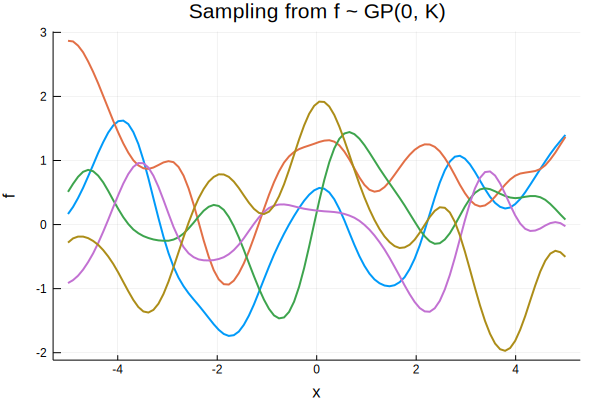

In [11]:
gp = GaussianProcess(GaussianKernel(1, 1))
xs = collect(range(-5, stop = 5, length = 100))

Plots.plot(xs, rand(gp, xs, 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "Sampling from f ~ GP(0, K)")

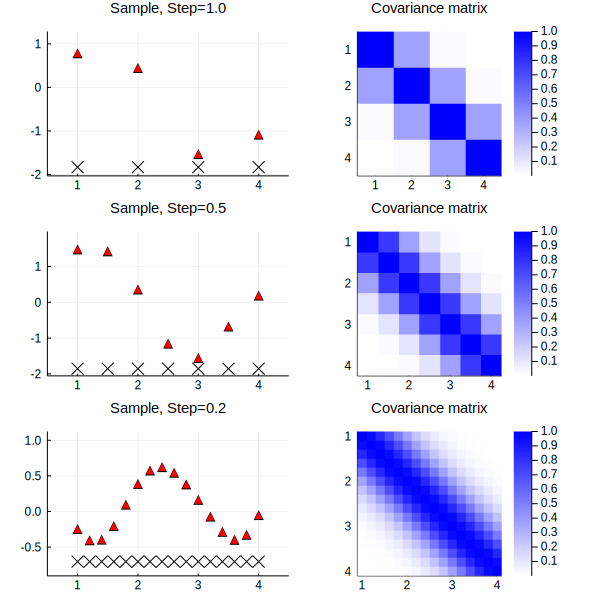

In [14]:
plts = []

xx = [1:4, 1:0.5:4, 1:0.2:4]
yy = [1, 0.5, 0.2]


for (x, y) in zip(xx, yy)
    x1 = collect(x)
    n = Base.length(x)
    sample = rand(gp, x1)
    sample_min = minimum(sample)
    sample_plot = scatter(x, sample, label = "",
            markershape = :utriangle, markercolor = :red,
            title = @sprintf("Sample, Step=%.1f", y), titlefontsize = 10)
    scatter!(x, fill(sample_min - 0.3, n),
        xlims = (0.5, 4.5),
        ylims = (sample_min - 0.5, maximum(sample) + 0.5),
        markershape = :x, markerstrokewidth = 2,
        label = "")
    push!(plts, sample_plot)
    push!(plts, heatmap(x1, x1, cov(gp, x1), 
            title = "Covariance matrix", titlefontsize = 10,
            aspect_ratio = :equal, yflip = true, color = cgrad([:white, :blue])))
end

Plots.plot(plts..., layout = (3, 2), size = [600, 600])

In [15]:
x1, x2 = 0:0.05:1, 0:0.05:1
n1, n2 = Base.length(x1), Base.length(x2)
n = n1 * n2
pt = permutedims(hcat([[i, j] for i in x1, j in x2]...))
sample = rand(gp, pt)
z = reshape(sample, n1, n2)

21×21 Array{Float64,2}:
 -0.542838   -0.645937   -0.743458   …  -0.260481   -0.13505     -0.0130333
 -0.566515   -0.664886   -0.753662      -0.195363   -0.0739479    0.044196 
 -0.583866   -0.675205   -0.756166      -0.122012   -0.00505876   0.105178 
 -0.593164   -0.68066    -0.75536       -0.0421381   0.0641216    0.170935 
 -0.600239   -0.676698   -0.7455         0.0404472   0.145265     0.241838 
 -0.599584   -0.668865   -0.726349   …   0.132911    0.230033     0.318921 
 -0.589977   -0.649538   -0.699823       0.227576    0.317709     0.400177 
 -0.57559    -0.628382   -0.66626        0.328545    0.411648     0.486291 
 -0.554038   -0.595336   -0.628133       0.428886    0.506601     0.575699 
 -0.526855   -0.560308   -0.582332       0.531402    0.605387     0.663146 
 -0.492545   -0.51555    -0.528908   …   0.637837    0.701034     0.754348 
 -0.454033   -0.46697    -0.472026       0.740028    0.800334     0.846948 
 -0.406736   -0.414361   -0.410558       0.840306    0.895864   

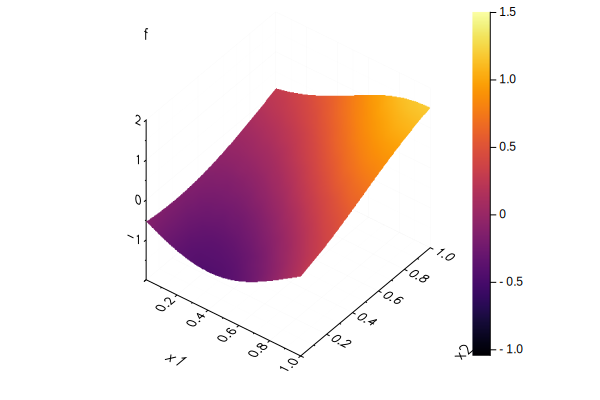

In [16]:
surface(x1, x2, z, alpha = 0.8, camera = (40, 60),
    linewidth = 2,
    framestyle = :grid,
    xlabel = "x1", ylabel = "x2", zlabel = "f")